In [36]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import time

from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from shrink_functions import X_y, ss
from model_functions import model_clusters, plot_rmse, clust_grid

In [3]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-bright')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
df = pd.read_pickle('data/SRP/clean_data_public_no_crime_lag2_by_cat.pkl')

In [5]:
cust_table_clust = pd.read_pickle('data/SRP/cust_table_clusters_biased.pkl')
df = df.join(cust_table_clust, on='address1', how='left')

# Split into features vs targets

In [6]:
# split into features and targets
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day', 'qty_start_inventory']
X, y = X_y(df, non_feature_cols, target_col='shrink_value_per_day')
# del df # free up memory

# random split for model testing (try/except based on customer seg being completed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X.cluster.values)

# Standardize and Scale

In [7]:
# save off non-scaled version (for naive comparison)
X_train_ns = X_train
X_test_ns = X_test

# standardize and scale data
X_train = ss(X_train, std=True, scale=True)
X_test = ss(X_test, std=True, scale=True)

In [24]:
X_train.head()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,cluster,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1_by_cat,qty_shrink_per_day_lag2_by_cat,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1_by_cat,shrink_value_per_day_lag2_by_cat,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
3039598,-0.942151,-0.966035,-0.550113,SPEEDWAY #7104,1203 MACARTHUR ST,MANCHESTER,3,2017-06-06 09:00:33,0.569871,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.585861,71941072001,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5 HR-XSTRENGTH GRAPE (728127),1626117,2017-06-06 09:00:33,0.569871,3386280,71941072001,1626117,2017-11-19,0.898754,2017-11-19,0.898754,3.915775,4.053100,-0.238870,2.162525,2.176603,100269115,100269115,-0.394911,208676,173813,0.629382,0.646210,TN,0.458476,-1.097146,2017-12-02,0.924562,37355
2606249,-0.518792,0.017554,0.017926,SPEEDWAY #9451,2400 TERRA CROSSING BLVD,L0UISVILLE,1,2016-09-20 09:01:00,0.055701,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.349641,60870716191,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ELEC-9' MICRO CHARGE/SYNC CABLE,2100134,2017-09-09 09:00:38,0.758466,3386280,60870716191,2100134,2017-09-21,0.781544,2017-10-19,0.837130,-0.474782,-0.459233,-0.413646,0.267933,0.285843,100018112,100018112,-0.528407,132370,160415,1.012338,1.032779,KY,-1.360979,0.733891,2017-11-02,0.864923,40245
2134072,-0.960671,-0.981271,-0.561468,SPEEDWAY #1182,1802 N CLINTON ST,DEFIANCE,3,2016-08-23 07:37:37,0.000000,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.581983,60870716188,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ELEC-4' MICRO CHARGE/SYNC CABLE,2100131,2016-08-23 07:37:38,0.000000,3386280,60870716188,2100131,2017-09-19,0.777574,2017-09-19,0.777574,-0.474782,-0.459233,-0.413646,-0.307348,-0.288274,100223113,100223113,-0.528407,118588,139080,-0.290276,-0.282125,OH,0.458476,0.126099,2017-10-03,0.805367,43512
2486004,0.127465,0.531412,0.074674,7 ELEVEN SBT PROGRAM #15560,171 BUCKALEW AVENUE,JAMESBURG,2,2016-08-23 07:37:37,0.000000,2773156,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.356446,60870716307,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SBT WIRELESS NECK EARBUD (BLACK),2673143,2017-02-05 10:00:33,0.329825,4513311,60870716307,2673143,2017-09-27,0.793456,2017-09-27,0.793456,-0.529664,-0.684850,-0.413646,-0.281780,-0.262758,100220113,100220113,-0.528407,158620,146803,-0.259456,-0.251015,NJ,-0.148009,1.139937,2017-10-25,0.849042,08831
2982516,-0.425395,-0.988375,-0.574742,MAVERIK #394,701 NORTH OVERLAND,BURLEY,3,2016-08-23 07:37:37,0.000000,2139,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.600576,60870712432,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,L4 LIFESTYLE SG 19.99,2279843,2017-03-29 14:15:47,0.433326,4908309,60870710202,1,2017-11-08,0.876917,2017-11-08,0.876917,-0.584546,-0.572042,-0.413646,-0.153940,-0.726691,100138113,100138113,-0.528407,70008,128995,0.040815,-0.856367,ID,-0.451251,0.859024,2017-11-29,0.918606,83318


In [8]:
# create mask of all numberical columns to be used in clustering/modeling

# including time features
numb_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.float32) | (X_train.dtypes == np.uint8)
numb_cols = X_train.columns[numb_mask]

# not including time features
numb_no_time_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.uint8)
numb_no_time_cols = X_train.columns[numb_no_time_mask]

# forcasting columns (what is known months ahead of time)
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'customer_id_1635139',
             'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
             'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
             'customer_id_2956160', 'customer_id_2977160', 'customer_id_3083182',
             'customer_id_3088198', 'customer_id_3088201', 'customer_id_3089336',
             'customer_id_3093327', 'customer_id_3093329', 'customer_id_3097348',
             'dens_sq_mile', 'shrink_value_per_day_lag1', 'shrink_value_per_day_lag2', 'unemp_rate']
# mask to be used in calculations
model_mask_cols = numb_no_time_cols

# Feature Importance
    - PCA
    - SVD
    - Random forest

## PCA

In [ ]:
def plot_var(pca):
    '''
    Input: fitted PCA
    '''
    var_arr = np.insert(pca.explained_variance_ratio_, [0], 0)
    cum_arr = np.cumsum(var_arr)
    feat_arr = np.arange(0, len(var_arr), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(feat_arr, var_arr, label='Variance at each point', c='r')
    plt.plot(feat_arr, cum_arr, label='Cumulative variance')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.ylabel('Fraction of total variance explained')
    plt.xlabel('Principal Component')
    plt.xticks(feat_arr);

In [ ]:
pca = PCA(10)
pca.fit(X_train[model_mask_cols])
plot_var(pca)

In [ ]:
pca.components_

## SVD

In [ ]:
svd = TruncatedSVD(n_components=10)
svd.fit(X_train[model_mask_cols])
plot_var(svd)

## K-means

In [24]:
def kmeans(X_km, clusters):
    SSE_arr = []
    ss_arr = []
    for i in clusters:
        kmeans = KMeans(n_clusters=i, n_jobs=-1)
        clust_dist = kmeans.fit_transform(X_km)
        clust_num = kmeans.predict(X_km)

        SSE = 0
        for a, b in zip(clust_dist, clust_num):
            SSE += a[b] ** 2
        SSE_arr.append(SSE)
        
        if i > 1:
            ss_arr.append(silhouette_score(X_km, clust_num))
    return SSE_arr, ss_arr

In [ ]:
clusters = np.arange(1, 20)
SSE_arr, ss_arr = kmeans(X_train[model_mask_cols], clusters)
elbow(clusters, SSE_arr)
silhouette(np.arange(2, 20), ss_arr)

In [26]:
def elbow(clusters, SSE_arr):
    plt.figure(figsize=(12,8))
    plt.title('Elbow Plot')
    plt.plot(clusters, SSE_arr)
    plt.grid(alpha=0.3)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squares Error (SSE)');

In [27]:
def silhouette(clusters, ss_arr):
    plt.figure(figsize=(12,8))
    plt.title('Silhouette Scores')
    plt.plot(clusters, ss_arr)
    plt.grid(alpha=0.3)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score');

## Heirarchal Clustering

In [ ]:
def heir_clust(X_hc, thresh, dist_metric='cosine', num_params_to_display=50):
    # Find distances using pair-wise distances in the array, according to desired metric
    dist = squareform(pdist(X_hc.values.T, metric = dist_metric))

    # Plot dendrogram
    fig, axarr = plt.subplots(nrows = 3, ncols = 1, figsize=(60, 80))
    for ax, linkmethod in zip(axarr.flatten(), ['single', 'complete', 'average']):
        clust = linkage(dist, method=linkmethod)
        dendrogram(clust, ax=ax, truncate_mode='lastp', p=num_params_to_display, labels=model_mask_cols, 
                   color_threshold=thresh, leaf_font_size=25) #color threshold number sets the color change
        ax.set_title('{} linkage'.format(linkmethod), fontsize=40)
        ax.grid(alpha=0.3)
    plt.savefig('images/clust.png'.format(linkmethod))

In [ ]:
heir_clust(X_train[model_mask_cols], thresh=1.6)

# Regression Models
Regression models to try:
    - Linear regression (with additional complexity)
    - Random forest
    - Boosting
    - Gradient descent
    - Neural net

## OLS

In [ ]:
def ols(X_train, X_test, y_train, y_test):
    ols = OLS(y_train, add_constant(X_train.values, has_constant='add'))
    result = ols.fit()
    pred = result.predict(add_constant(X_test.values, has_constant='add'))
    score = mean_squared_error(y_test, pred)
    print('Root Mean Square Error: ',score)
    names = list(X_train.columns)
    names.insert(0,'Constant')
    print(result.summary(xname=names))

In [ ]:
ols(X_train[model_mask_cols], X_test[model_mask_cols], y_train, y_test)

In [ ]:
for val in X_train.item_category.unique():
    print('Item cat: ', val)
    mask = X['item_category_{}'.format(val)] == 1
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X[mask], y[mask], test_size=0.2)
    size = len(X_train_temp)
    print('Size: ', size)
    if size < 30:
        continue
    ols(X_train_temp[model_mask_cols], X_test_temp[model_mask_cols], y_train_temp, y_test_temp)

## multiple Sklear models

In [ ]:
def class_crossval(X, y, models, scoring='neg_mean_absolute_error'):
    results = []
    names = []
    all_scores = []
    print('Mod - Avg - Std Dev')
    print('---   ---   -------')
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.2f} ({:2f})'.format(name, cv_results.mean(), cv_results.std()))
    
    fig = plt.figure(figsize=(25, 18))
    plt.tight_layout()
    fig.suptitle('Algorithm Comparison of CrossVal Scores')
    ax = fig.add_subplot(111)
    sb.violinplot(data=results, orient='v')
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel('K-Fold CV Negative Mean Abs. Error')
    ax.set_xlabel('Model')
    plt.grid(alpha=0.4)
    #plt.savefig('images/model_selection_shrink_value.png')

In [ ]:
# Initial Cross Validation
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Elastic Net', ElasticNet()))
#models.append(('Stochastic Gradient Descent', SGDRegressor(max_iter=10000, tol=0.001)))
#models.append(('Support Vector Regression', SVR(max_iter=10000)))
models.append(('K Nearest Neighbors', KNeighborsRegressor(n_jobs=-1)))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
#models.append(('AdaBoost', AdaBoostRegressor(n_estimators=100)))
models.append(('Gradient Boost', GradientBoostingRegressor()))
models.append(('Multi-Layer Perceptron', MLPRegressor(alpha=1)))

class_crossval(X_train[model_mask_cols], y_train, models)

## Grid Search

### Random Forest

In [35]:
model = RandomForestRegressor()
params = {'n_estimators': [10, 30], 'max_features': [5, 10, 15], 'max_depth': [None, 20], 'n_jobs': [-1]}
clust_grid(model, params, X_train, y_train, model_mask_cols)


cluster:  1


KeyboardInterrupt: 

### MLP

In [ ]:
model = MLPRegressor()
# params = {'hidden_layer_sizes': [(100,), (50,50), (50,50,50)], 'learning_rate_init': [0.01, 0.001, 0.0001], 
#           'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['adam'],  'max_iter': [300]}
params = {'hidden_layer_sizes': [(10)], 'learning_rate_init': [0.01], 
          'activation': ['relu'], 'solver': ['adam'],  'max_iter': [10]}
clust_grid(model, params, X_train, y_train, model_mask_cols)


cluster:  1


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/

{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.0001, 'max_iter': 300, 'solver': 'adam'}


cluster:  2


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}


cluster:  3


# Splitting By Cluster

Average:  0.40561269029072144
Std. Dev.:  1.532391323064075


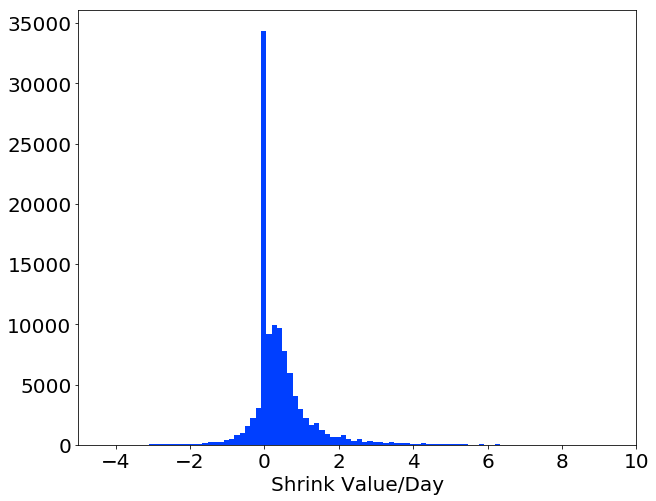

In [8]:
value_dist = df.shrink_value_per_day.values
plt.figure(figsize=(10,8))
plt.hist(value_dist, bins=2000)
#plt.yscale('log')
plt.xlim(xmin=-5, xmax=10)
plt.xlabel('Shrink Value/Day')

print('Average: ', value_dist.mean())
print('Std. Dev.: ',value_dist.std())

In [13]:
X_train.groupby('cluster').count()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1_by_cat,qty_shrink_per_day_lag2_by_cat,qty_start_inventory,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1_by_cat,shrink_value_per_day_lag2_by_cat,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194
1,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826
2,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120,34120
3,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201,25201


In [26]:
rf = RandomForestRegressor(n_estimators=100, max_features=10, n_jobs=-1)

mlp1 = MLPRegressor(alpha=0.001, solver='adam', activation='tanh', hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=400)
mlp2 = MLPRegressor(alpha=0.001, solver='adam', activation='tanh', hidden_layer_sizes=(100,), learning_rate_init=0.0001, max_iter=400)
mlp3 = MLPRegressor(alpha=0.001, solver='adam', activation='relu', hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=400)
mlp4 = MLPRegressor(alpha=0.001, solver='adam', activation='relu', hidden_layer_sizes=(100,), learning_rate_init=0.0001, max_iter=400)
mlp_list = [mlp1, mlp2, mlp3, mlp4]

cluster_rmse, naive_rmse, cluster_models = model_clusters(mlp_list, X_train, X_test, X_test_ns, 'shrink_value_per_day_lag1_by_cat', model_mask_cols, y_train, y_test)

cluster:  1
cluster:  2
cluster:  3
cluster:  4


Average decrease: 16.8%


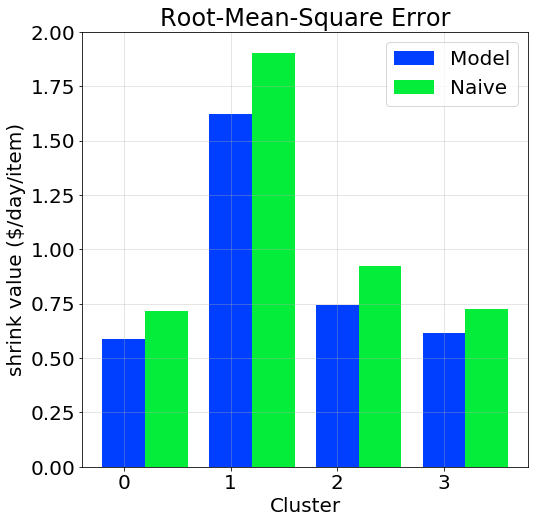

In [23]:
plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X_train.cluster.unique()))

## LSTM

In [ ]:
def fit_lstm(X, y, batch_size, nb_epoch, neurons):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 1
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(X_train[model_mask_cols], y_train, 1, 3, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

# Forcasting/Time Series
 - Inclusion of endog (target) variable into predictive model/forcast
 - Explore various techniques outlined statsmodels.pdf
 - Try LSTM neural net

In [ ]:
plt.scatter(X_train.prev_item_move_date_int.values, X_train.prev_visit_date_int.values, alpha=0.01)

In [ ]:
foo = df[ df.address1 == 'SPEEDWAY #1224']
plt.figure(figsize=(12,12))
plt.scatter(foo.visit_date.values, foo.qty_shrink.values, c=foo.item_UPC.values)
plt.xticks(rotation=45)
plt.legend()

In [ ]:
def cat_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Cat')
    
cat_plot_sales()

In [ ]:
def cat_plot_shrink():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.qty_shrink, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Shrink/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Shrink Loss Across All Stores by Cat')
    
    
cat_plot_shrink()

In [ ]:
def st_plot_sales():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.sales_value, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Lost Sales/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Sales Loss Across Cat by State')
    
st_plot_sales()

In [ ]:
def cust_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['customer_id', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(16,10))
    plt.tight_layout()
    i = 1
    for cust in item_filt.customer_id.unique():
        if cust == '2741156':
            continue
        foo = item_filt[ item_filt.customer_id == cust]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cust)
        #ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Customer')
    #plt.yscale('log')
    
    
cust_plot_sales()

In [ ]:
plt.figure(figsize=(20,4))
plt.scatter(df.visit_date.values, df.shrink_value.values, alpha=0.2)
plt.yscale('log')
plt.yticks([0.1,1,10])


In [ ]:
df.groupby(['state', pd.Grouper(key='visit_date', freq='w')]).head()

In [ ]:
def st_plot_shrink():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.qty_shrink, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Shrink/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Shrink Loss Across Cat by State')
    
st_plot_shrink()

In [ ]:
crime = pd.read_pickle('data/Crime/crime_clean.pkl')

In [ ]:
def crime_plot():
    freq = 'w'
    item_filt = crime.groupby([pd.Grouper(key='date', freq=freq)]).count().reset_index()
    plt.figure(figsize=(20,8))
    plt.plot(item_filt.date, item_filt.city)
    plt.grid(alpha=0.4)
crime_plot()

In [ ]:
def fit_lstm(X_train, y, batch_size, nb_epoch, neurons):
    X = X_train[]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
fit_lstm(X_train, y, None, 1, 20)

# Questions
1. Why are there two salesman ID columns?
2. Which columns are unknown (ie anything inventory out or equivalent)?
3. Target is qty_shrink?
4. What does customer_id represent? It has more values than address1

# Other Data Sources
 - Crime data
 - Food desserts (people that may rely on gas stations for food)
 - Average income
 - Population density

In [ ]:
pd.get_dummies(df, columns=['state'])

In [ ]:
foo = pd.DataFrame()
foo[['a', 'b']] = df[['visit_date', 'address1']]

In [ ]:
foo.head()

# POA
- Create averages:
    - Avg qty shrink/day, shink_sales/day, etc
- Engineer lag terms (ie last visit, last month, last season)
    - Use these in whatever model I want
    - Use the averaged values